In [77]:
# Import Dependencies

import pandas as pd
from fbprophet import Prophet
import requests
from pprint import pprint
from datetime import datetime, timedelta



In [46]:
# Read Bitcoin daily data from Alpha Vantage API

av_api_key = 'IYOYBP274BRSLPM0'

url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CAD&apikey={av_api_key}"

data = requests.get(url).json()
bc_data = data["Time Series (Digital Currency Daily)"]

In [47]:
# Loop through json response API data and transform into lists in python to create pandas dataframe

date = []
open_CAD = []
open_USD = []
high_CAD = []
high_USD = []
low_CAD = []
low_USD = []
close_CAD = []
close_USD = []
volume = []

date = list(bc_data.keys())

for d in date:
  value = bc_data[d]
  close_CAD.append(value['4a. close (CAD)'])
  close_USD.append(value['4b. close (USD)'])
  volume.append(value['5. volume'])
  open_CAD.append(value['1a. open (CAD)'])
  open_USD.append(value['1b. open (USD)'])
  high_CAD.append(value['2a. high (CAD)'])
  high_USD.append(value['2b. high (USD)'])
  low_CAD.append(value['3a. low (CAD)'])
  low_USD.append(value['3b. low (USD)'])

In [48]:
# Create Pandas dataframe

df = pd.DataFrame({"Date": date, "Open_CAD": open_CAD, "Open_USD": open_USD, "High_CAD": high_CAD, "High_USD": high_USD, "Low_CAD": low_CAD, "Low_USD": low_USD, "Close_CAD": close_CAD, "Close_USD":close_USD, "Volume":volume})
df.head()

,Date,Open_CAD,Open_USD,High_CAD,High_USD,Low_CAD,Low_USD,Close_CAD,Close_USD,Volume
0,2021-03-11,70489.17470720,55851.59000000,71307.49475840,56499.98000000,70051.75040000,55505.00000000,70558.18524160,55906.27000000,2447.14674600
1,2021-03-10,69256.22351360,54874.67000000,72427.85579520,57387.69000000,66896.55040000,53005.00000000,70489.17470720,55851.59000000,84749.23894300
2,2021-03-09,66101.66717440,52375.18000000,69281.88160000,54895.00000000,65362.37857280,51789.41000000,69268.62976000,54884.50000000,71656.73707600
3,2021-03-08,64314.47354880,50959.11000000,66136.50058240,52402.78000000,62188.57551360,49274.67000000,66101.65455360,52375.17000000,66987.35966400
4,2021-03-07,61693.24697600,48882.20000000,64934.05386240,51450.03000000,61693.24697600,48882.20000000,64330.42624000,50971.75000000,55235.02803200


In [49]:
# Facebook Prophet Model Setup

fb_df = df[["Date", "Close_USD"]]
fb_df = fb_df.rename(columns={"Date": "ds", "Close_USD": "y"})
fb_df.head()

,ds,y
0,2021-03-11,55906.27000000
1,2021-03-10,55851.59000000
2,2021-03-09,54884.50000000
3,2021-03-08,52375.17000000
4,2021-03-07,50971.75000000


In [50]:
# Create fbProphet model and fit model 
model = Prophet()
model.fit(fb_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
# Model 90 days in the future

future_df = model.make_future_dataframe(periods=90)

In [52]:
#Make predictions

predictions = model.predict(future_df)
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1085,2021-06-05,65788.734946,67049.096582,76544.642848,60751.893565,70156.841774,6512.515454,6512.515454,6512.515454,-4.528919,-4.528919,-4.528919,6517.044373,6517.044373,6517.044373,0.0,0.0,0.0,72301.250400
1086,2021-06-06,65989.313360,67246.544653,77187.518172,60879.698527,70396.509222,6482.830839,6482.830839,6482.830839,-44.479746,-44.479746,-44.479746,6527.310585,6527.310585,6527.310585,0.0,0.0,0.0,72472.144200
1087,2021-06-07,66189.891775,67518.072608,77649.256525,61011.242419,70611.271196,6566.214536,6566.214536,6566.214536,26.930936,26.930936,26.930936,6539.283600,6539.283600,6539.283600,0.0,0.0,0.0,72756.106311
1088,2021-06-08,66390.470190,67558.732845,78050.444943,61102.900754,70861.588093,6532.848827,6532.848827,6532.848827,-19.696175,-19.696175,-19.696175,6552.545002,6552.545002,6552.545002,0.0,0.0,0.0,72923.319017
1089,2021-06-09,66591.048605,67699.191774,78240.049084,61147.055479,71134.936010,6627.945294,6627.945294,6627.945294,61.303910,61.303910,61.303910,6566.641384,6566.641384,6566.641384,0.0,0.0,0.0,73218.993899


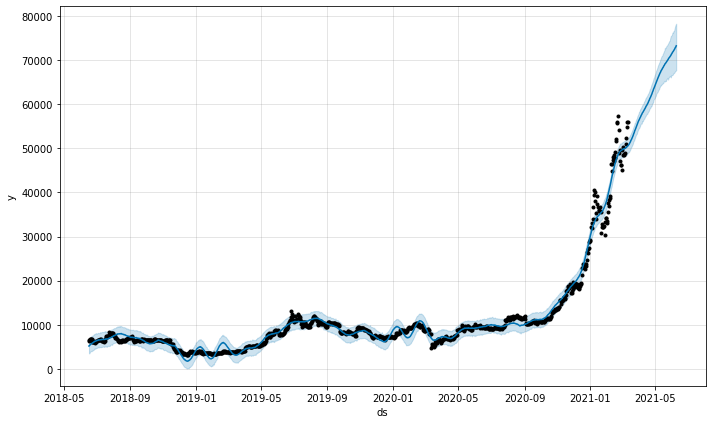

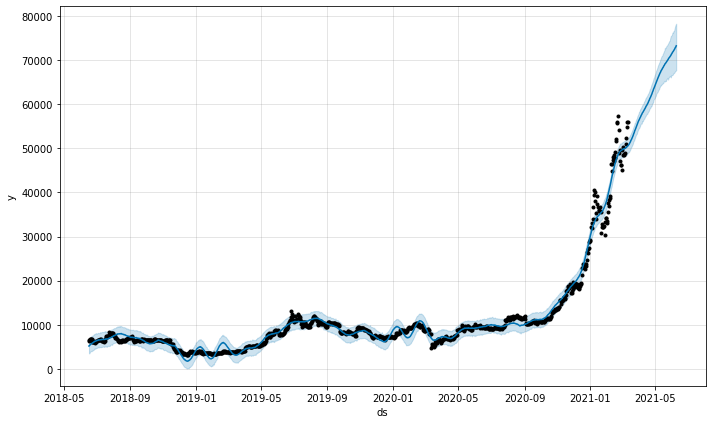

In [53]:
# Plot Predictions
model.plot(predictions)

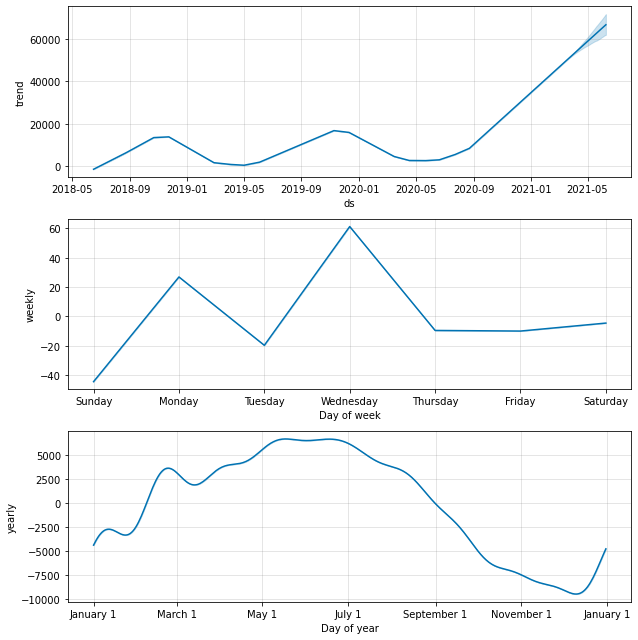

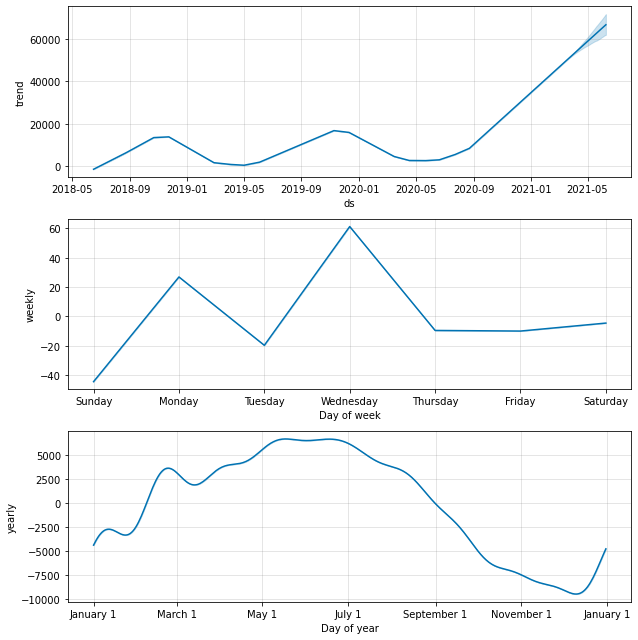

In [44]:
# Plot model components

model.plot_components(predictions)

In [84]:
#Use the NY Times API to pull recent Bitcoin news

nyt_api_key = 'AHD58yFBu6t1DV7UGF2hdMCyfo2PvaHq'
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# Store a search term
query = "Bitcoin"

# Search for articles published between a begin date (90 days ago) and end date (current date)

end_date = datetime.today()
begin_date = end_date - timedelta(90)

end_date = end_date.strftime('%Y%m%d')
begin_date = begin_date.strftime('%Y%m%d')


query_url = f"{url}api-key={nyt_api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Retrieve articles
articles = requests.get(query_url).json()


In [89]:
# Transform API response into pandas df

headline = []
date = []
paragraph = []

articles_list = articles["response"]["docs"]

for article in articles_list:
  headline.append(article["headline"]["main"])
  date.append(article["pub_date"])
  paragraph.append(article["lead_paragraph"])

news_df = pd.DataFrame({"Date": date, "Headline": headline, "Paragraph": paragraph})
news_df['Date'] = pd.to_datetime(news_df['Date'], infer_datetime_format=True)
news_df.head(10)

,Date,Headline,Paragraph
0,2021-03-09 11:47:50,Bitcoin’s Climate Problem,“Bitcoin uses more electricity per transaction...
1,2021-03-09 13:08:01,Why Bill Gates Is Worried About Bitcoin,Bitcoin is continuing to climb — its price is ...
2,2021-02-09 12:39:32,Bitcoin’s Big Day,Cryptocurrency prices are soaring after Tesla ...
3,2021-02-08 13:32:43,"Tesla says it bought $1.5 billion of Bitcoin, ...",The electric-car maker Tesla is known for buck...
4,2021-03-01 10:00:12,China Charges Ahead With a National Digital Cu...,Annabelle Huang recently won a government lott...
5,2021-02-03 16:20:09,What Can You Actually Buy With Bitcoin?,"In the last twelve months, the value of a sing..."
6,2021-02-22 12:09:37,Billion-Dollar Paydays in a Pandemic,"Today, Institutional Investor unveiled the 20t..."
7,2021-02-22 08:00:10,Why an Animated Flying Cat With a Pop-Tart Bod...,To hear more audio stories from publishers lik...
8,2021-01-29 14:00:08,"As Bitcoin’s Price Surges, Affluent Investors ...",Cryptocurrencies have soared in value. In a de...
9,2021-02-10 12:33:50,The Issues With SPACs,"On Feb. 22-23, DealBook will bring together so..."
